# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1051]:
import pandas as pd
import numpy as np
import math
import json
#% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

### 1. Data Exploration (Portfolio Data)

In [1052]:
#Printing top5 rows from portfolio data
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [1053]:
#Printing number of rows and columns in portfolio dataframe
print("portfolio data: Rows = {0}, Columns = {1}".format(str(portfolio.shape[0]), str(portfolio.shape[1])))

portfolio data: Rows = 10, Columns = 6


In [1054]:
#Showing details in form of quantile, max, min , mean, standard deviation etc
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [1055]:
#Printing datatype info about attributes of portfolio dataset
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [1056]:
# Checking the null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [1057]:
# Exploring different attributes under channel column in portfolio dataset
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

#### 1.1 Portfolio Data Cleaning

In [1058]:
# First of all we need to separate the values of channels attribute and create separate table for values of channels 
# I will apply the concept of dummy columns, I will rename the column "id" as "offer_id", as its part of portfolio's offer.
"""
.apply(pd.Series) converts the series of lists to a dataframe
.stack() puts everything in one column again (creating a multi-level index)
pd.get_dummies( ) creating the dummies
.sum(level=0) for remerging the different rows that should be one row (by summing up the second level, only keeping the original level (level=0))
"""
df1= portfolio.copy()

dummy = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)
df1 = pd.concat([df1, dummy], axis=1)
df1 = df1.drop(columns='channels')
df1 = df1.rename(columns={'id':'offer_id'})
df1.head()


,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


### 2.Data Exploration (Profile Data)

In [1059]:
# Printing top5 rows of profile data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1060]:
#Row and Column detail about profile data
profile.shape

(17000, 5)

In [1061]:
#Quantile, min, max etc info about profile data
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [1062]:
profile.describe(include="all")

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,cd8a88670e404eef9d4edc3010dd84aa,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


In [1063]:
# Printing all values under age attribute of profile dataset
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

In [1064]:
# Datatype information of profile attributes
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [1065]:
# Checking the null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

#### 2.1 Profile data cleaning

In [1066]:
# Checking the type of became_member_on attribute, as it contains value in the format of yy/mm/dd
type(profile.became_member_on[0])

numpy.int64

In [1067]:
# Creating copy of dataframe for further implementaion, we need to change the type of "became_member_on" attribute 
# We will change the column name "id" to "customer_id"
df2 = profile.copy()

df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], format='%Y%m%d')

df2 = df2.rename(columns={'id':'customer_id'})
df2.head(15)


,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN


#####  From above it looks like, that all null values belong to "age=118"

In [1068]:
# Checking the above fact
df2[df2['age']== 118].drop(['became_member_on', 'customer_id'], axis=1)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


In [1069]:
# Cross checking the type of "became_member_on" attribute
type(df2.became_member_on[0])

pandas._libs.tslibs.timestamps.Timestamp

### 3. Data Exploration (Transcript Data)

In [1070]:
# Print the transcript data 
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1071]:
# Printing rows and columns of transcript.json file
transcript.shape

(306534, 4)

In [1072]:
# Printing quantile, mean, max,min etc about transcript file
transcript.describe(include="all")

,person,event,value,time
count,306534,306534,306534,306534.000000
unique,17000,4,5121,NaN
top,94de646f7b6041228ca7dec82adb97d2,transaction,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN
freq,51,138953,14983,NaN
mean,NaN,NaN,NaN,366.382940
std,NaN,NaN,NaN,200.326314
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,186.000000
50%,NaN,NaN,NaN,408.000000
75%,NaN,NaN,NaN,528.000000


In [1073]:
# Displaying information about data type of transcript attributes
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [1074]:
# Displaying the type of value and number of values against offer id
transcript['value'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 439.14}                                      1
{'amount': 42.75}                                       1
{'amount': 650.75}                                      1
{'amount': 943.4}                                       1
{'amount': 44.21}                                       1
Name: value, Length: 5121, dtype: int64

In [1075]:
# Displaying the type of event and number of those event
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [1076]:
# Checking the null value. if it is present in transcript data set
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

#### 3.1 Cleaning Transcript Data

In [1077]:
"""
First we will create another copy of transcript dataset like profile and portfolio.
Will chnage the column name 'person' to 'customer_id'
Convert the column 'event' into 4 different columns, based on their types. Will apply the concept of dummy.

"""
df3 = transcript.copy()

df3['event'] = df3['event'].str.replace(' ', '-')

df3 = df3.rename(columns={'person':'customer_id'})
dummy = pd.get_dummies(df3['event'])
df3 = pd.concat([df3, dummy], axis=1 )
df3.head()


,customer_id,event,value,time,offer-completed,offer-received,offer-viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [1078]:
# This code is picked from https://stackoverflow.com/questions/60106364/syntaxerror-invalid-syntax-when-using-lambda-function-in-pandas-apply
df3['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df3.value]
df3['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df3.value]

In [1079]:
# Dropping the value column 
df3 = df3.drop(columns='value')
df3.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Now We are done with data exploration and cleaning for all three datasets. Now as per need we will combine the data from all three datasets and draw visualization.

### Based on common attributes of all three datasets, we will try to merge the datasets.

In [1080]:
# First will start to merge transcript and profile data on 'cutomer id'
df_merge= pd.merge(df3, df2, on='customer_id')
df_merge.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,75,2017-05-09,100000.0


In [1081]:
# Merge the portfolio dataset with df_merge dataframe
df = pd.merge(df_merge, df1, on='offer_id', how='left')
df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,None,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,None,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [1082]:
df.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [1083]:
# Lets try some graph based on the findings of so far, before that lets find mean value
df['income'].mean()

64337.00075523717

In [1084]:
type(df['time'])

pandas.core.series.Series

<AxesSubplot:xlabel='time', ylabel='Density'>

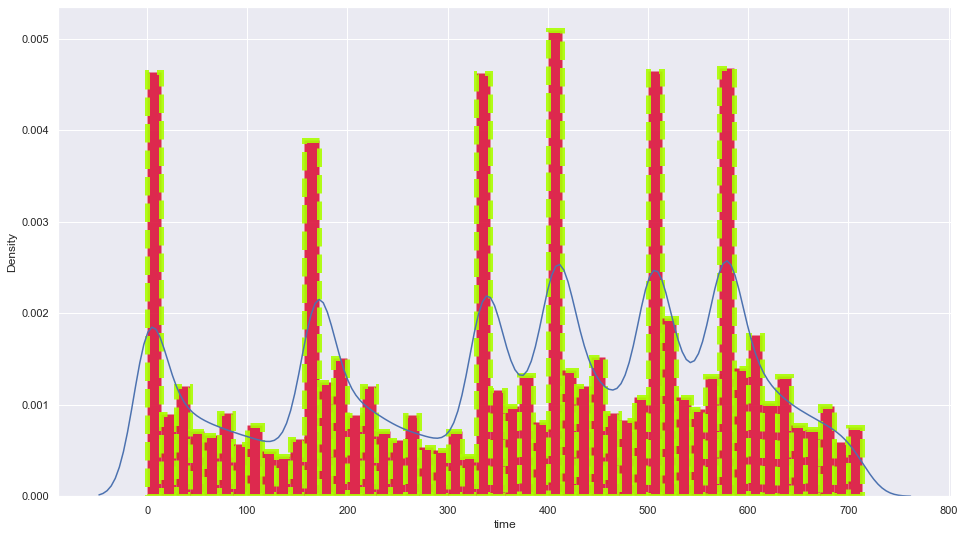

In [1085]:
# distplot plot based on time attribute 
# This code is picked from https://indianaiproduction.com/seaborn-histogram-using-seaborn-distplot/
"""
Time attribute is related to offer_id, customer_id and other important attributes directly, so its 
important here to check maximum number of offers provided for particular category, as of now I am not 
defining 'time' attribute with respect to other attribute. I am just considering 'time' attribute alone.
"""
plt.figure(figsize=(16,9))
sns.set()
 
# hist keyword argument to change hist format
sns.distplot(df["time"],
            hist_kws = {'color':'#DC143C', 'edgecolor':'#aaff00',
                       'linewidth':5, 'linestyle':'--', 'alpha':0.9})

<AxesSubplot:title={'center':' Distribution of offer_ids'}>

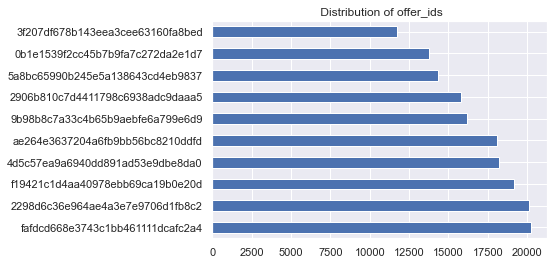

In [1086]:
df['offer_id'].value_counts().plot.barh(title=' Distribution of offer_ids')


In [1087]:
#Number of rows and columns in df dataframe
df.shape

(306534, 21)

In [1088]:
# Detailed information about df dataframe in terms of quantile, mean, deviation, min, max etc
df.describe(include='all')

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
count,306534,306534,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,167581,138953.000000,272762,...,306534,272762.000000,167581.00000,167581.000000,167581.000000,167581,167581.0,167581.000000,167581.000000,167581.000000
unique,17000,4,NaN,NaN,NaN,NaN,NaN,10,NaN,3,...,1716,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,94de646f7b6041228ca7dec82adb97d2,transaction,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,M,...,2017-12-07 00:00:00,NaN,NaN,NaN,NaN,bogo,NaN,NaN,NaN,NaN
freq,51,138953,NaN,NaN,NaN,NaN,NaN,20241,NaN,155690,...,754,NaN,NaN,NaN,NaN,71617,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2013-07-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2018-07-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,366.382940,0.109544,0.248837,0.188315,0.453304,NaN,12.777356,NaN,...,NaN,64337.000755,4.41991,7.850401,6.610737,NaN,1.0,0.917944,0.656996,0.806858
std,NaN,NaN,200.326314,0.312321,0.432340,0.390964,0.497815,NaN,30.250529,NaN,...,NaN,21243.762941,3.37336,5.048944,2.136130,NaN,0.0,0.274451,0.474714,0.394765
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.050000,NaN,...,NaN,30000.000000,0.00000,0.000000,3.000000,NaN,1.0,0.000000,0.000000,0.000000
25%,NaN,NaN,186.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.780000,NaN,...,NaN,48000.000000,2.00000,5.000000,5.000000,NaN,1.0,1.000000,0.000000,1.000000


In [1089]:
#Data type information about the attributes of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   event             306534 non-null  object        
 2   time              306534 non-null  int64         
 3   offer-completed   306534 non-null  uint8         
 4   offer-received    306534 non-null  uint8         
 5   offer-viewed      306534 non-null  uint8         
 6   transaction       306534 non-null  uint8         
 7   offer_id          167581 non-null  object        
 8   amount            138953 non-null  float64       
 9   gender            272762 non-null  object        
 10  age               306534 non-null  int64         
 11  became_member_on  306534 non-null  datetime64[ns]
 12  income            272762 non-null  float64       
 13  reward            167581 non-null  float64       
 14  diff

In [1090]:
df['offer_id'].nunique()

10

In [1091]:
# Find all unique values of offer_id
offer_id = df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [1092]:
# Convert the offer_id values into dictionary form
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [1093]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [1094]:
# mapping the offer_id with offer_dict, in order to get  
df['offer_id'] = df['offer_id'].map(offer_dict)
df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,1,19.89,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,1,17.78,F,...,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,9,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,9,NaN,None,...,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,9,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,9,NaN,F,...,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [1095]:
type(df['became_member_on'])

pandas.core.series.Series

In [1096]:
df['offer_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [1097]:
event_id = df['event'].unique()
event_id

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'],
      dtype=object)

In [1098]:
#in order to make compare and visualize all factors related to company promotions, like offers, event, we need to create co relation 
# between all factors, so that we can create more clear visualization. Here I am creating separate column, called event_id
# which is mapped according to event attribute.
event_dict = pd.Series(event_id).to_dict()

event_dict = dict([(value, key) for key, value in event_dict.items()]) 
df['event_id'] = df['event'].map(event_dict)
df

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,1,19.89,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,3
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,1,17.78,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,9,NaN,None,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,9,NaN,None,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,9,NaN,F,...,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,9,NaN,F,...,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1


In [1099]:
# Lets cross check structure of dataframe
df.shape

(306534, 22)

In [1100]:
#converting the dataframe into csv data
df.to_csv('data/data.csv', index=False)


In [1101]:
data = pd.read_csv('data/data.csv')
data

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,1,19.89,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,3
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,1,17.78,F,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer-received,576,0,1,0,0,9,NaN,NaN,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,0
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer-viewed,594,0,0,1,0,9,NaN,NaN,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1
306531,3045af4e98794a04a5542d3eac939b1f,offer-received,576,0,1,0,0,9,NaN,F,...,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,0
306532,3045af4e98794a04a5542d3eac939b1f,offer-viewed,576,0,0,1,0,9,NaN,F,...,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1


In [1102]:
# Exploring data file
data.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [1103]:
data.gender.unique()

array(['F', nan, 'M', 'O'], dtype=object)

In [1104]:
data.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

## 4. Visualization of cleaned data

In [1105]:
def horizontal_bar_plot(data, colName, pltTitle, pltfigsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    colName: The name of the column containing the categories.
    pltTitle: The plot title.
    pltfigsize: The figure size of the plot (default is [5,5]).
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    fntSize: The font size of text (default to 12 point font size)
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_counts = data[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

### Visualization #1

<Figure size 360x360 with 0 Axes>

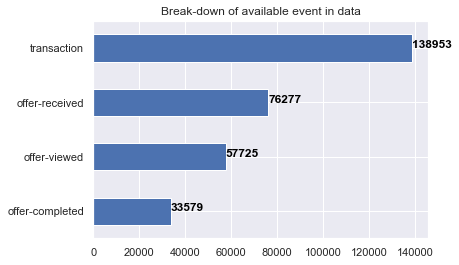

In [1106]:
# Pulling number of event categories as per cleaned data
horizontal_bar_plot(data, 'event', "Break-down of available event in data")

#### Observation : From above graph it is clear that only approx half offers reach to audience and out of that only 1/3 offers are completed by customers. Many offers dont even get seen after receiving.  

### Visualization#2

<Figure size 360x360 with 0 Axes>

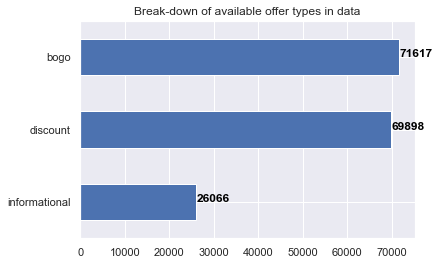

In [1107]:
horizontal_bar_plot(data, 'offer_type', "Break-down of available offer types in data")

#### Observation: Bogo and discount offers have similar distributions, but Bogo comes on top. Thats why many patterns are coming based on Bogo in market.

### Visualization#3

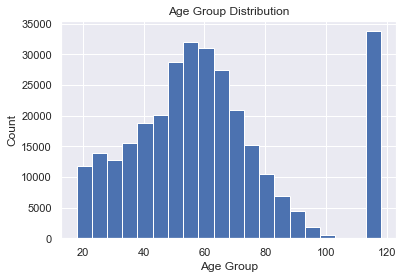

In [1108]:
# Using histogram trying to pull outliers
data.age.hist(bins = 20, grid=True)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

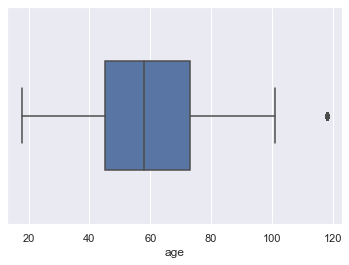

In [1109]:
# Using box plot trying to pull outliers
sns.boxplot(profile['age'], width=0.5);

### Observation : 
##### Based on above two plots (histogram & Boxplot), we can see that age>100 is present , which is not possible. So will consider values above 
#### 100 as outlier. Age group between 47-62 use application the most. 63-71 age group uses the Starbuck app second most, as any
#### one may think here that younger age group must be using the app mostly. But this is not true here.

### Visualization#4

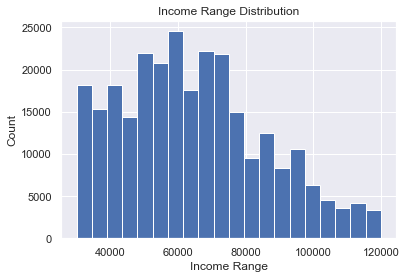

In [1110]:
# Using histogram trying to pull outliers
data.income.hist(bins = 20, grid=True)
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

#### Observation : Average income is 65000-74000

### Visualization#5

In [1111]:
data['gender'].value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [1112]:
data['gender'].value_counts().sum()

272762

In [1113]:
print("Male gender population  : {} % " .format(str(data.gender.value_counts()[0] / data.shape[0]*100)))
print("Female gender population  : {} % " .format(str(data.gender.value_counts()[1] / data.shape[0]*100)))
print("Other gender population  : {} %" .format(str(data.gender.value_counts()[2] / data.shape[0]*100)))

Male gender population  : 50.79045065147749 % 
Female gender population  : 36.89672271265177 % 
Other gender population  : 1.2954517280301696 %


<Figure size 360x360 with 0 Axes>

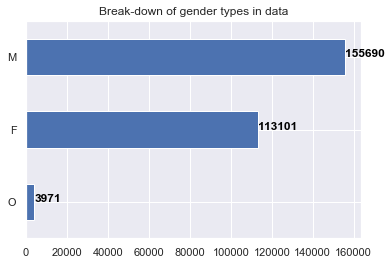

In [1114]:
horizontal_bar_plot(data, 'gender', "Break-down of gender types in data")

#### Observation : Male is playing major role towards using Starbucks app

### Visualization#6

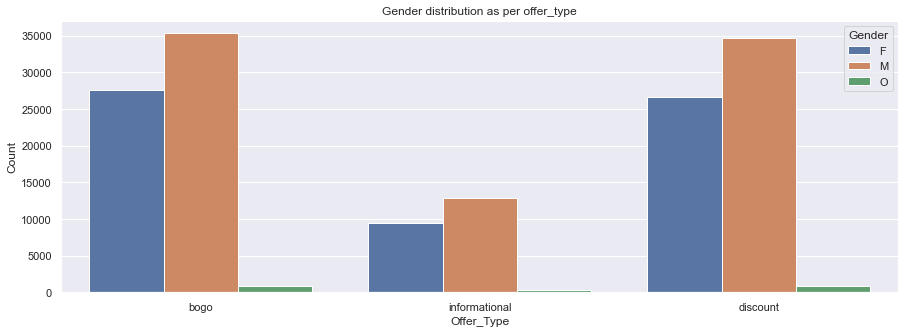

In [1115]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=data)
sns.set(style="darkgrid")
plt.title('Gender distribution as per offer_type')
plt.ylabel('Count')
plt.xlabel('Offer_Type')
plt.xticks(rotation=0)
plt.legend(title='Gender')

#### Observation : As we can see here , that Male are using the all types of offers mostly. Informational type offer is close for male and female.

### Visualization# 7

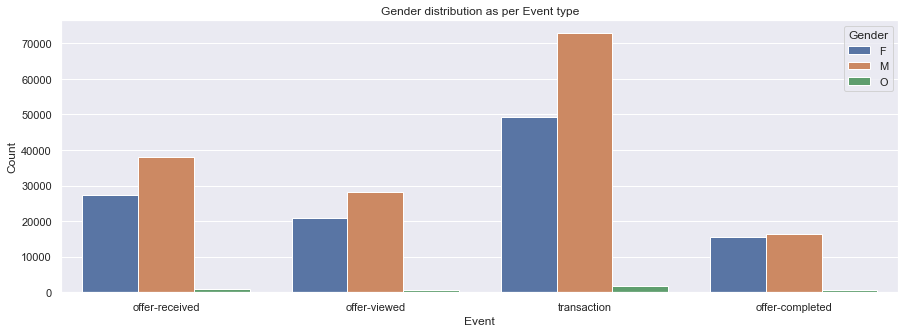

In [1116]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=data)
sns.set(style="darkgrid")
plt.title('Gender distribution as per Event type')
plt.ylabel('Count')
plt.xlabel('Event')
plt.xticks(rotation=0)
plt.legend(title='Gender')

#### Observation: Here are few intresting facts about event type disrtibution among the gender. As we can see that there is huge gap between offer-received and offer-completed. But under offer-completed event, male and female got almost same number of count. Which indicates that male usually ignores the offers mostly or dont pay attention towards it, whereas female pays more attention towards offer. Which seems to be correct in real life as well :)

### Visualization# 8

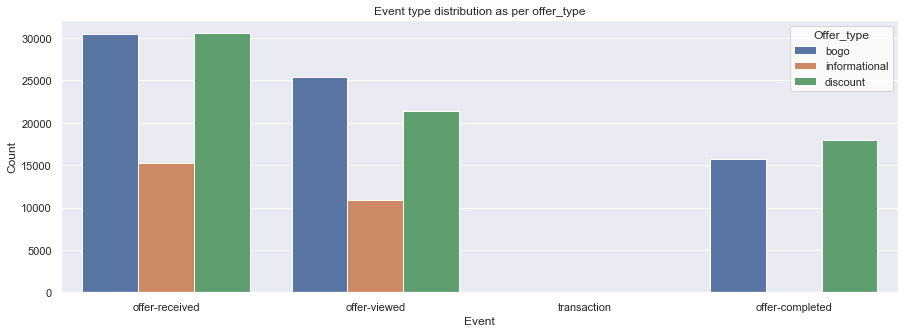

In [1117]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=data)
sns.set(style="whitegrid")
plt.title('Event type distribution as per offer_type')
plt.ylabel('Count')
plt.xlabel('Event')
plt.xticks(rotation=0)
plt.legend(title='Offer_type')

#### Observation : As we can see in above chart, that bogo and discount offers get receive in almost same quantity, but discount offers have less views compared to bogo offer, still discount offers are larger then bogo offer in terms of offer-completed category. 

### Visualization# 9

In [1118]:
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()

 
print("Offer-Received as per types : {}".format(str(offer_received)))
print("Offer-Viewed as per types : {}".format(str(offer_viewed)))
print("Offer-Completed as per types : {}".format(str(offer_completed)))

Offer-Received as per types : 0     7677
5     7668
3     7658
10    7646
7     7632
2     7618
6     7617
8     7597
9     7593
4     7571
Name: offer_id, dtype: int64
Offer-Viewed as per types : 10    7337
8     7327
9     7298
4     7264
3     6716
2     6687
0     4171
6     4144
7     4118
5     2663
Name: offer_id, dtype: int64
Offer-Completed as per types : 8     5317
10    5156
0     4354
4     4296
7     4017
3     3688
5     3420
9     3331
Name: offer_id, dtype: int64


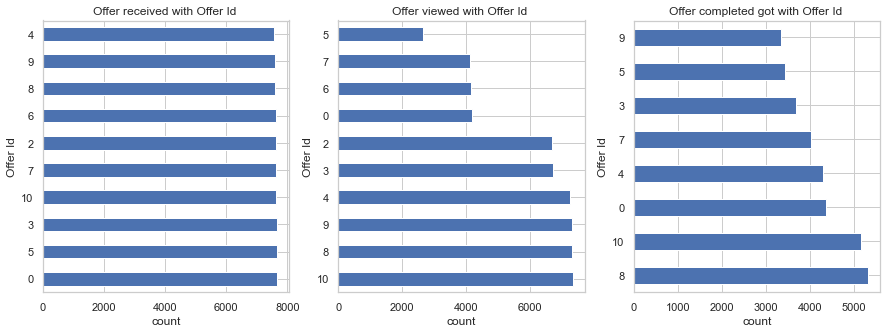

In [1119]:
# Defining three subplots with grid size 1*3 for 1st subplot, with grid size 1*3 for 2nd subplot, with 1*3 grid size for 3rd subplot.
plt.subplot(1,3,1)
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='barh', figsize=(15,5))
plt.ylabel('Offer Id')
plt.xlabel('count')
plt.title('Offer received with Offer Id ');

plt.subplot(1,3,2)
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='barh' , figsize=(15,5))
plt.ylabel('Offer Id')
plt.xlabel('count')
plt.title('Offer viewed with Offer Id ');

plt.subplot(1,3,3)
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='barh' , figsize=(15,5))
plt.ylabel('Offer Id')
plt.xlabel('count')
plt.title('Offer completed got with Offer Id ');

#### Observation: From above subplots we can analyze that all Offer id received equal offers and 60% offer ids did view the offer in terms of good count, rest 40% is on average mark. If we talk about offer completion with respect to offer ids, then its showing considerably good count for all offer ids. 

### Visualization# 10

In [1120]:
# Here I am pulling three platforms where offers get shoot up mostly, email, mobile and social platforms.
email_received = df1[df1['email'] == 1].offer_id.value_counts()
mobile_received = df1[df1['mobile'] == 1].offer_id.value_counts()
social_received = df1[df1['social'] == 1].offer_id.value_counts()

 
print("email-Received as per types : {}".format(str(email_received)))
print("mobile-Viewed as per types : {}".format(str(mobile_received)))
print("social-Completed as per types : {}".format(str(social_received)))

email-Received as per types : f19421c1d4aa40978ebb69ca19b0e20d    1
5a8bc65990b245e5a138643cd4eb9837    1
2906b810c7d4411798c6938adc9daaa5    1
ae264e3637204a6fb9bb56bc8210ddfd    1
fafdcd668e3743c1bb461111dcafc2a4    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
3f207df678b143eea3cee63160fa8bed    1
Name: offer_id, dtype: int64
mobile-Viewed as per types : 5a8bc65990b245e5a138643cd4eb9837    1
2906b810c7d4411798c6938adc9daaa5    1
ae264e3637204a6fb9bb56bc8210ddfd    1
fafdcd668e3743c1bb461111dcafc2a4    1
f19421c1d4aa40978ebb69ca19b0e20d    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
3f207df678b143eea3cee63160fa8bed    1
Name: offer_id, dtype: int64
social-Completed as per types : 2298d6c36e964ae4a3e7e9706d1fb8c2    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
ae264e3637204a6fb9bb56bc8210ddfd    1
5a8bc65990b245e

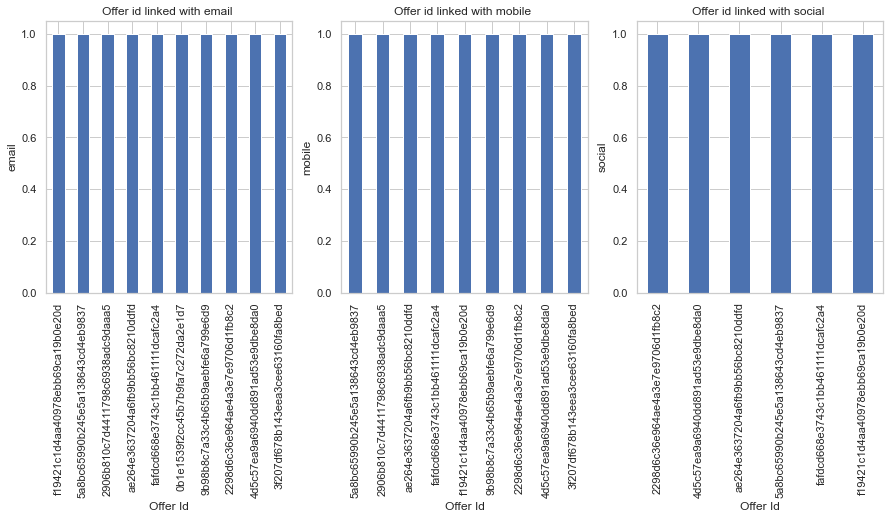

In [1121]:
# Defining three subplots with grid size 1*3 for 1st subplot, with grid size 1*3 for 2nd subplot, with 1*3 grid size for 3rd subplot.
plt.subplot(1,3,1)
email = df1[df1['email'] == 1].offer_id.value_counts()
email.plot(kind='bar')
plt.ylabel('email')
plt.xlabel('Offer Id')
plt.title('Offer id linked with email ');

plt.subplot(1,3,2)
mobile = df1[df1['mobile'] == 1].offer_id.value_counts()
mobile.plot(kind='bar' , figsize=(15,5))
plt.ylabel('mobile')
plt.xlabel('Offer Id')
plt.title('Offer id linked with mobile ');

plt.subplot(1,3,3)
social = df1[df1['social'] == 1].offer_id.value_counts()
social.plot(kind='bar' , figsize=(15,5))
plt.ylabel('social')
plt.xlabel('Offer Id')
plt.title('Offer id linked with social ');

#### Observation : As we can see here offers get shoot up on email mostly. or can say first preference for Starbucks. Second its Mobile, and its also very popular medium for shooting offers. Mobile platform is almost equal to email. Social platform is bit low in terms of shooting offers, as its showing 60% compared to email. So may be Starbucks can consider to boost up the offers over social platform.

## Conclusion :

Analysis 1 : Based on gender type distribution according to dataset, males use Starbucks app mostly, but females also play great role.

Analysis 2: Based on event(offer-received, offer-viewed, offer-completed) and offer type (BOGO, discount, informational), discount offer gets completed mostly, whereas BOGO offer gets seen mostly.

Analysis 3: All offer ids received the offer but view percentage is approx 30% lower and completion rate is still good and satisfactory.

Analysis 4: Event type distribution as per gender indicates that for all types males are playing major role. Offer completed is almost same for male and female.
 
Analysis 5: As per age group distribution , we found that Age group between 47-62 use application the most. 63-71 age group uses the Starbuck app second most, as anyone may think here that younger age group must be using the app mostly. But this is not true here.

Based on above analysis we found that number of males are playing major role, but here is twist, as we can see that offer received by males is much higher then females but when it comes about offer completion, there is very low margin between both gender. So percentage wise females come on top, so company should consider to send the offers to females mostly.

### Data Modelling Prepration

For data modelling prepration, we will analyze few facts once again and mold them as per requirement of the modal for 
required algorithm.

In [1122]:
transcript = pd.get_dummies(transcript , columns=['event'] , prefix='' ,prefix_sep='')
transcript.head()

,person,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [1123]:
transcript.isna().sum()

person             0
value              0
time               0
offer completed    0
offer received     0
offer viewed       0
transaction        0
dtype: int64

In [1124]:
# Remove outliers (age 118)
remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)

In [1125]:
#profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [1126]:
# store 0 and 1s in new columns
profile['missing'] = profile['age'].apply(lambda val: 1 if pd.isna(val) else 0)
dropped = profile[profile['missing'] == 1].index
# cleaned Dataset
clean_profile = profile.drop(dropped)

In [1127]:
# Remove outliers (age 118)
remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)

In [1128]:
clean_profile.head()

,gender,age,id,became_member_on,income,missing
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0


In [1129]:
Model_data = data.groupby(['customer_id' , 'offer_type']).agg(
    {
         'offer-completed':sum,   
         'offer-received': sum, 
         'offer-viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }
).reset_index()

In [1130]:
def offers_transformation(df):
    '''
    Function: to transform the ofers
    
    Returns: The transformed offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer-completed']
            df.loc[index , 'bogo_received'] = row['offer-received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer-completed']
            df.loc[index , 'discount_received'] = row['offer-received']
        
        
        
    return df.groupby(['customer_id']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()

In [1131]:
trans_data = offers_transformation(Model_data)


In [1132]:
trans_data.head()

,customer_id,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,00116118485d4dfda04fdbaba9a87b5c,118,2018-04-25,NaN,NaN,2,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
3,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
4,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1


In [1133]:
#trans_data['gender'].fillna(0, inplace=True)

In [1134]:
# create colunms with the precnetage of each offer
trans_data['bogo_perce'] = trans_data.bogo_completed.div(trans_data.bogo_received.where(trans_data.bogo_received != 0, np.nan))*100
trans_data['discount_perce'] = trans_data.discount_completed.div(trans_data.discount_received.where(trans_data.discount_received != 0, np.nan))*100

In [1135]:
trans_data.fillna(0 , inplace=True)


In [1136]:
trans_data.isna().sum()


customer_id           0
age                   0
became_member_on      0
gender                0
income                0
bogo_received         0
bogo_completed        0
discount_received     0
discount_completed    0
bogo_perce            0
discount_perce        0
dtype: int64

In [1137]:
trans_data['bogo_offer'] = 0
trans_data['discount_offer'] = 0


for i ,row in trans_data.iterrows():

    if(row['bogo_perce'] >= 80):
        trans_data.loc[i , 'bogo_offer'] = 1
        
    if(row['discount_perce'] >= 80 ):
        trans_data.loc[i , 'discount_offer'] = 1

In [1138]:
trans_data['year'] = pd.DatetimeIndex(trans_data['became_member_on']).year
trans_data.head()

,customer_id,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed,bogo_perce,discount_perce,bogo_offer,discount_offer,year
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2,100.0,100.0,1,1,2017
1,00116118485d4dfda04fdbaba9a87b5c,118,2018-04-25,0,0.0,2,0,0,0,0.0,0.0,0,0,2018
2,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2,100.0,100.0,1,1,2018
3,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2,50.0,100.0,0,1,2016
4,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1,100.0,100.0,1,1,2016


In [1139]:
trans_data['month'] = pd.DatetimeIndex(trans_data['became_member_on']).month
trans_data.head()

,customer_id,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed,bogo_perce,discount_perce,bogo_offer,discount_offer,year,month
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2,100.0,100.0,1,1,2017,4
1,00116118485d4dfda04fdbaba9a87b5c,118,2018-04-25,0,0.0,2,0,0,0,0.0,0.0,0,0,2018,4
2,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2,100.0,100.0,1,1,2018,1
3,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2,50.0,100.0,0,1,2016,3
4,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1,100.0,100.0,1,1,2016,11


In [1145]:
Model_data2 = trans_data.copy()
Model_data2['year'] = pd.to_datetime(Model_data2.became_member_on).dt.year
Model_data2['month'] =pd.to_datetime(Model_data2.became_member_on).dt.month
#Model_data2['year'] = Model_data2.became_member_on.year
#Model_data2['month'] = Model_data2.became_member_on.month

#Model_data2['year'] = pd.to_datetime(df['became_member_on'], errors='coerce')
#Model_data2['year'] = Model_data2['became_member_on'].dt.strftime('%m/%d')

#Model_data2['month'] = pd.to_datetime(df['became_member_on'], errors='coerce')
#Model_data2['month'] = Model_data2['became_member_on'].dt.strftime('%m/%d')


In [1146]:
Model_data2 = Model_data2[['age' , 'gender' , 'income' ,
                           'year' , 'month' , 'discount_offer' ,
                           'bogo_offer']]

In [1147]:
Model_data3 = pd.get_dummies(Model_data2 , columns=['gender'])


In [1148]:
X = Model_data3.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = Model_data3.bogo_offer
y_discount = Model_data3.discount_offer

In [1149]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

#### Let's build KNN classifier model.
First, import the KNeighborsClassifier module and create KNN classifier object by passing argument number of neighbors in KNeighborsClassifier() function or we can leave it empty if it is not reqired, in my cased its not required so I am leaving it empty.
Then, fit your model on the train set using fit() 

In [1168]:
model1_bogo = KNeighborsClassifier()
model1_discount = KNeighborsClassifier()
model1_bogo.fit(X_train, y_bogo_train)
model1_discount.fit(X_train, y_discount_train)
#predicted= model1_bogo.predict([[0,3]]) 
#print(predicted)

KNeighborsClassifier()

In [1152]:
print('Bogo offer F1_score {}'.format( model1_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(model1_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model1_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model1_discount.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6381326010200078
Bogo offe Test F1_score 0.606495646034361
Discount offer Training F1_score 0.7406041584935269
Discount offer Test F1_score 0.5937867733584373


#### Building Gaussian Naive Bayes modal



In [1153]:
model2_bogo = GaussianNB()
model2_discount = GaussianNB()
model2_bogo.fit(X_train, y_bogo_train)
model2_discount.fit(X_train, y_discount_train)

GaussianNB()

In [1154]:
print('Bogo offer F1_score {}'.format( model2_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(model2_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model2_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model2_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.6404864652805021
Bogo offe Test F1_score 0.6512120498940928
Discount offer Training F1_score 0.6230678697528442
Discount offer Test F1_score 0.6340315368321958


#### Building SVC modal, its imported from SVM

In [1155]:
model3_bogo = SVC()
model3_discount = SVC()
model3_bogo.fit(X_train, y_bogo_train)
model3_discount.fit(X_train, y_discount_train)

SVC()

In [1156]:
print('Bogo offer F1_score {}'.format( model3_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(model3_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model3_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model3_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.615300117693213
Bogo offe Test F1_score 0.6147328783243116
Discount offer Training F1_score 0.6305217732444096
Discount offer Test F1_score 0.6349729348081902


#### Adaboost Algorithm or boosting algorithm

In [1157]:
model4_bogo = AdaBoostClassifier()
model4_discount = AdaBoostClassifier()
model4_bogo.fit(X_train, y_bogo_train)
model4_discount.fit(X_train, y_discount_train)

AdaBoostClassifier()

In [1158]:
print('Bogo offer F1_score {}'.format( model4_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(model4_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model4_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model4_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.6777559827383287
Bogo offe Test F1_score 0.6747469992939515
Discount offer Training F1_score 0.6934484111416241
Discount offer Test F1_score 0.6893386679218639


In [1159]:
def get_predict(customer , offer):
    '''
    Function: to get the prediction
    
    Input: customer, offer
    
    output: prediction
    
    '''
    predict_bogo = 0
    predict_discount = 0 
    

    predict_bogo = model4_bogo.predict(customer.values)[0]
    predict_discount = model4_discount.predict(customer.values)[0]
    
    if(predict_bogo == 0 & predict_discount == 0):
        print('No Response!')

        
    if (offer == 'bogo'):
        if(predict_bogo == 0):
            if(predict_discountt == 1):
                print('preferred discount')           
        else:
            print('Bogo choice')
    if (offer == 'discount'):
        if(predict_discount == 0):
            if(predict_bogo == 1):
                print('preferred bogo')           
        else:
            print('Discount choice')

In [1173]:
# Prdedicting 
get_predict(X_test[0:3] ,'bogo')


Bogo choice


### Conclusion & Recommendation :

Based on Visualization part, we can see that BOGO offer and discount offers are most popular and there is good competition between both types, but from bar chart it is clear that BOGO is most popular.

In modelling section I have applied four types of algorithm, KNN, Gaussian, SVM and Adabooster, from these four algorithm we have tried to predict F1 score for all , and found that its highest for Kneighbours Classifier modal i.e "Discount offer Training F1_score = 0.74 " 
Hence it is clear Company should promote discount offer, in order to improve accuracy.
